# Description

# Introduction
This task simulates the experiences and challenges a hexafarms' data scientist faces in helping farmers.

## Main evaluation points
 - Processing, visualization, and analysis of the dataset
 - Application of theoretical knowledge to derive insights and predictive models from the dataset
 - Effective presentation of your findings and solutions

## Background
Strawberry grower A is having difficulty forecasting their weekly production quantities. Hexafarms' engineering team has provided you with a dataset, and your mission is to analyze this data to create value for the farmers. This includes offering a predictive model or strategy for more accurate harvest forecasting.

## Tasks / Steps
 - Data Processing: The dataset is incomplete and requires preprocessing (i.e., handling missing values, aligning start and end times, etc.).
 - Data Visualization and Analysis: Create effective visualizations and analyze the dataset, keeping the APP development team in mind as ## your target audience.
 - Hypothesis Presentation: Based on your analysis, present hypotheses for building a predictive harvest model.
 - Predictive Model Code: Write pseudo-code or actual code for the predictive model.
 - [Optional] Model Validation: If possible, validate your predictive model.

# Imports

In [1]:
import pandas as pd
import sklearn
# from dataprep.eda import plot_correlation, plot_missing, plot_diff, create_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

input_path = 'input_data/'
output_path = 'preprocessed_data/'
%run utils.py
%run datapreprocessing 

# Loading

In [2]:
image_process_outcome_df = load_json(input_path + 'image_process_outcome.json')
sensor_environment_df = load_json(input_path + 'sensor_environment.json')
user_harvest_record_df = load_json(input_path + 'user_harvest_record.json')

# Preprocessing

In [3]:
preprocess = DataPreprocessing(sensor_df=sensor_environment_df, 
                               image_df=image_process_outcome_df,
                               entries_df=user_harvest_record_df)

image_df = preprocess.image_df.copy()
sensor_df = preprocess.sensor_df.copy()
entries_df = preprocess.entries_df.copy()

# Missing values

## image_process

In [4]:
# plot_missing(image_df)
image_df.isnull().sum()

counts_red              1
counts_turning          1
counts_white            1
counts_smallgreen       1
counts_fruitset         1
counts_flower           1
avg_areas_red           1
avg_areas_turning       1
avg_areas_white         1
avg_areas_smallgreen    1
avg_areas_fruitset      1
avg_areas_flower        1
date                    0
dtype: int64

## sensor_environment

In [5]:
# plot_missing(sensor_df)
sensor_df.isnull().sum()

PAR                65
Air_Humidity        0
Air_Temperature     0
Air_CO2             0
hour                0
date                0
dtype: int64

There are few missed values of air information. Easier to drop these raws.

For fill missing values of PAR column let's look at correlation 

In [6]:
sensor_df = sensor_df.dropna(subset='Air_Humidity')
# plot_correlation(sensor_df)
sensor_df.corr()

C:\Users\USER\AppData\Local\Temp\ipykernel_14268\2928874260.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sensor_df.corr()


,PAR,Air_Humidity,Air_Temperature,Air_CO2,hour
PAR,1.000000,-0.717261,0.671083,0.045221,-0.075397
Air_Humidity,-0.717261,1.000000,-0.759313,0.138788,-0.099187
Air_Temperature,0.671083,-0.759313,1.000000,-0.071282,0.154497
Air_CO2,0.045221,0.138788,-0.071282,1.000000,-0.104405
hour,-0.075397,-0.099187,0.154497,-0.104405,1.000000


## Use xgboost to fill nan values
As we can see, PAR has high positive correlation with temperature and high negative with others. Let's make simple model when PAR would be target and other columns would be features.


In [7]:
# prepare for data analysis
data_for_par_missing_model = sensor_df.dropna()

feature = data_for_par_missing_model[['Air_Humidity', 'Air_Temperature',]]

target = data_for_par_missing_model[['PAR']]


# Feature engineering

## image_process

<Axes: xlabel='date'>

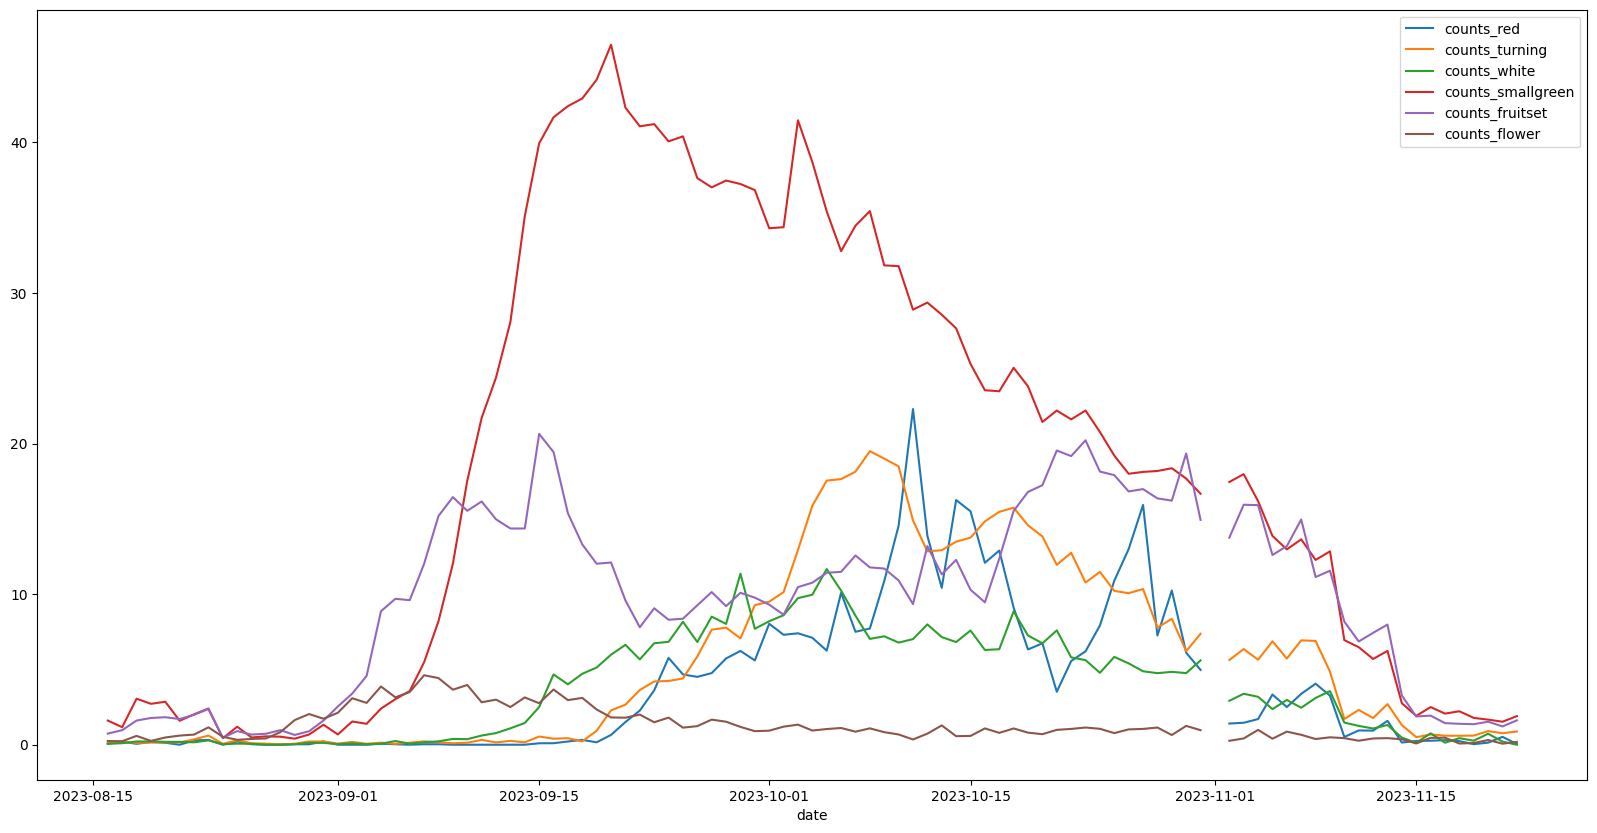

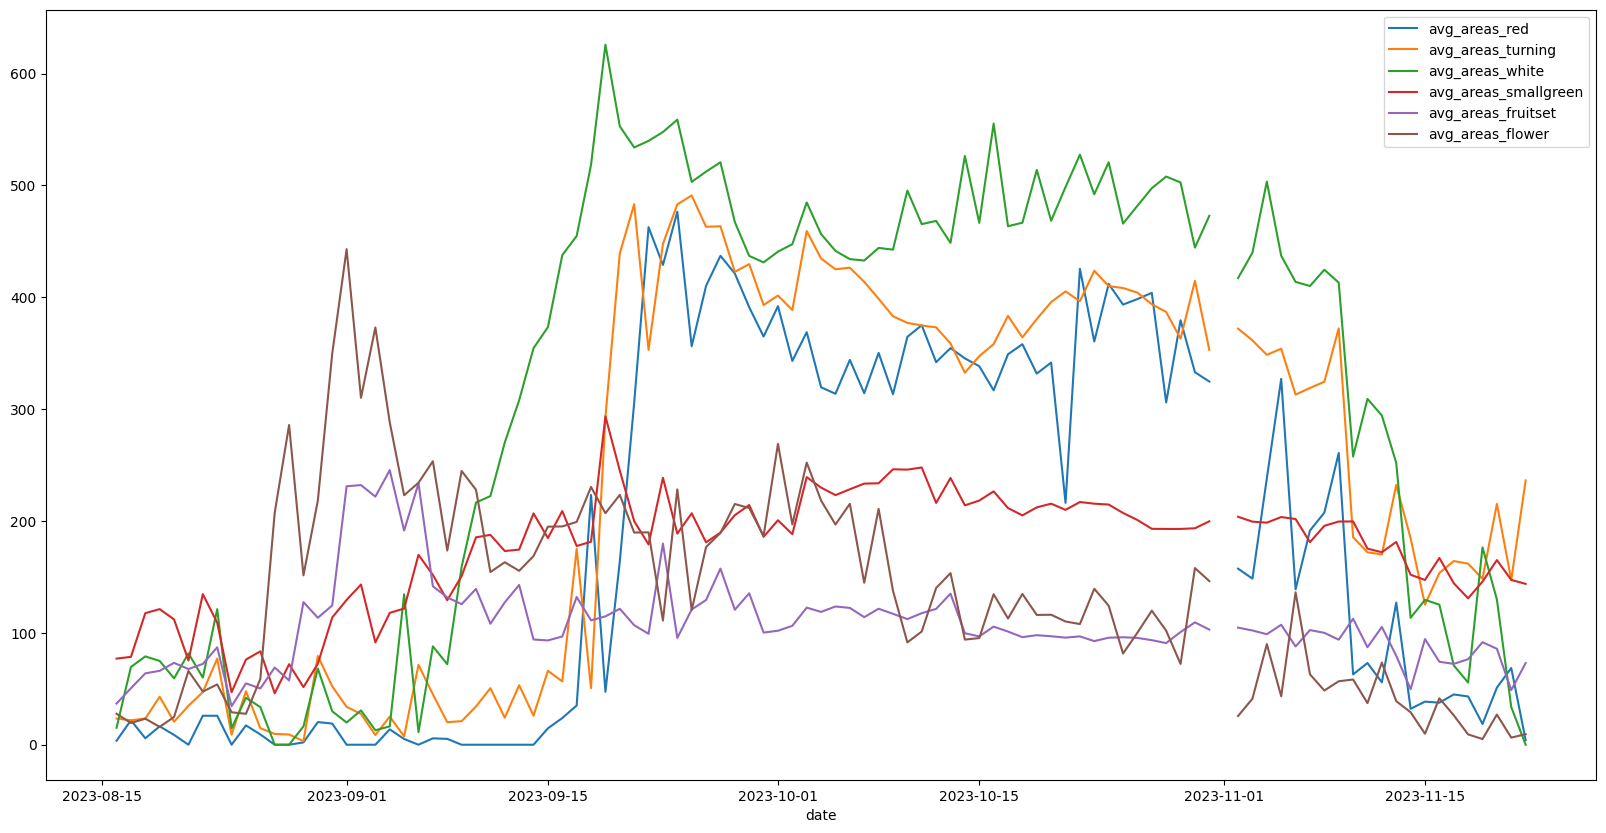

In [8]:
image_df.plot('date', ['counts_red', 'counts_turning', 'counts_white', 'counts_smallgreen','counts_fruitset','counts_flower'], figsize=(20, 10))
image_df.plot('date', [ 'avg_areas_red', 'avg_areas_turning', 'avg_areas_white', 'avg_areas_smallgreen',
       'avg_areas_fruitset', 'avg_areas_flower',], figsize=(20, 10))

    We don't have info about each phase, but we could assume, that full cycle is the difference between the first harvest date and the first flower data

In [9]:
full_cycle = (pd.to_datetime(entries_df['date'].min()) - pd.to_datetime(image_df['date'].min())).days
print(full_cycle)
phase_flower = 7
phase_fruitset = 7
phase_smallgreen = 8
phase_white = 7
phase_turning = 2
phase_red = 3

34


# Hypothes
Previos phase has influence on current. And current conditions have influence on current state. 

In [10]:
flower_final_df, fruitset_final_df, smallgreen_final_df, white_final_df, turning_final_df, red_final_df = preprocess.processing()

In [11]:
red_final_df = red_final_df.merge(entries_df[['date', 'value']])

In [12]:
flower_final_df.to_csv(output_path + 'flower.csv.gz', index=False)
fruitset_final_df.to_csv(output_path + 'fruitset.csv.gz', index=False)
smallgreen_final_df.to_csv(output_path + 'smallgreen.csv.gz', index=False)
white_final_df.to_csv(output_path + 'white.csv.gz', index=False)
turning_final_df.to_csv(output_path + 'turning.csv.gz', index=False)
red_final_df.to_csv(output_path + 'red.csv.gz', index=False)